# Guessing NBA games winner

# Can we predict NBA games based on previous matches?

## Importing libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report

## preparing the dataframe

In [2]:
df = pd.read_csv("nba_games.csv", index_col=0)
df = df.sort_values("date") #sorting the values by date, because we have a time series project
df = df.reset_index(drop=True)

In [3]:
df
#here we take a quick look at the dataframe to get an understanding how it looks

,mp,mp.1,fg,fga,fg%,3p,3pa,3p%,ft,fta,...,tov%_max_opp,usg%_max_opp,ortg_max_opp,drtg_max_opp,team_opp,total_opp,home_opp,season,date,won
0,240.0,240.0,35.0,83.0,0.422,6.0,18.0,0.333,19.0,27.0,...,69.4,43.7,206.0,104.0,GSW,111,1,2016,2015-10-27,False
1,240.0,240.0,38.0,94.0,0.404,9.0,29.0,0.310,10.0,17.0,...,53.2,34.6,162.0,104.0,CHI,97,1,2016,2015-10-27,False
2,240.0,240.0,37.0,87.0,0.425,7.0,19.0,0.368,16.0,23.0,...,30.4,29.0,138.0,105.0,CLE,95,0,2016,2015-10-27,True
3,240.0,240.0,41.0,96.0,0.427,9.0,30.0,0.300,20.0,22.0,...,37.5,38.9,201.0,120.0,NOP,95,0,2016,2015-10-27,True
4,240.0,240.0,37.0,82.0,0.451,8.0,27.0,0.296,12.0,15.0,...,33.3,23.6,132.0,104.0,DET,106,0,2016,2015-10-27,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17767,240.0,240.0,34.0,85.0,0.400,15.0,38.0,0.395,14.0,19.0,...,42.9,36.3,133.0,112.0,GSW,107,0,2022,2022-06-10,False
17768,240.0,240.0,41.0,88.0,0.466,9.0,40.0,0.225,13.0,15.0,...,45.0,94.4,300.0,112.0,BOS,94,0,2022,2022-06-13,True
17769,240.0,240.0,31.0,75.0,0.413,11.0,32.0,0.344,21.0,31.0,...,33.3,36.2,222.0,107.0,GSW,104,1,2022,2022-06-13,False
17770,240.0,240.0,34.0,80.0,0.425,11.0,28.0,0.393,11.0,12.0,...,33.3,31.5,186.0,111.0,GSW,103,0,2022,2022-06-16,False


In [4]:
# we can see there are some columns that we dont neeed.
del df["mp.1"] # repeating value, same as mp
del df["mp_opp.1"] # repeating value, same asa mo_opp
del df["index_opp"] # an index value, we dont need that it tells no informatin about the game played
del df["home_opp"] # reapiting value, home_opp tells the opposite of home 
del df["date"] # dont need the date, it tells no value about the game played

# columns with "%" in them, calcute its value by 2 other columns we already have so its just repeating values
#for example we have fg(field goal) and fga(field goal attempted), fg% gets calculated by those 2 values(we dont gain any new information)

# columns with "max" in them, shows informaton about an individual player(for example the max goals a player scored from the team)
# we dont want to use this informtion since it might mislead the model, beacuse the player that scored max goals in a previous game
# might not be plaing the current game and we dont have any info on who was the player that got the max

for col in df.columns:
    if "%" in col or "max" in col:
        del df[col]

df = df.dropna(axis=1) # removeing columns that have no values

In [5]:
df
#check if any of the dataframe manipulations we did went wrong

,mp,fg,fga,3p,3pa,ft,fta,orb,drb,trb,...,pf_opp,pts_opp,3par_opp,ftr_opp,ortg_opp,drtg_opp,team_opp,total_opp,season,won
0,240.0,35.0,83.0,6.0,18.0,19.0,27.0,8.0,25.0,33.0,...,29.0,111.0,0.313,0.229,110.9,94.9,GSW,111,2016,False
1,240.0,38.0,94.0,9.0,29.0,10.0,17.0,11.0,39.0,50.0,...,22.0,97.0,0.218,0.264,97.5,95.5,CHI,97,2016,False
2,240.0,37.0,87.0,7.0,19.0,16.0,23.0,7.0,40.0,47.0,...,21.0,95.0,0.309,0.181,95.5,97.5,CLE,95,2016,True
3,240.0,41.0,96.0,9.0,30.0,20.0,22.0,21.0,35.0,56.0,...,26.0,95.0,0.217,0.325,94.9,110.9,NOP,95,2016,True
4,240.0,37.0,82.0,8.0,27.0,12.0,15.0,7.0,33.0,40.0,...,15.0,106.0,0.302,0.271,111.2,98.6,DET,106,2016,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17767,240.0,34.0,85.0,15.0,38.0,14.0,19.0,11.0,31.0,42.0,...,21.0,107.0,0.473,0.165,112.6,102.1,GSW,107,2022,False
17768,240.0,41.0,88.0,9.0,40.0,13.0,15.0,4.0,35.0,39.0,...,16.0,94.0,0.427,0.413,97.9,108.4,BOS,94,2022,True
17769,240.0,31.0,75.0,11.0,32.0,21.0,31.0,8.0,39.0,47.0,...,28.0,104.0,0.455,0.170,108.4,97.9,GSW,104,2022,False
17770,240.0,34.0,80.0,11.0,28.0,11.0,12.0,11.0,30.0,41.0,...,20.0,103.0,0.500,0.087,111.8,97.7,GSW,103,2022,False


The columns in the dataframe got down to 47, which does not look like a lot
but we still want to remove some columns 
that might add noise to the model (to make it more accurate)

Also since we are working with time series later we will get some new columns with the information 
from previous games. And we dont want to have too many attributes, that would slow down the model

In [6]:
df.columns

Index(['mp', 'fg', 'fga', '3p', '3pa', 'ft', 'fta', 'orb', 'drb', 'trb', 'ast',
       'stl', 'blk', 'tov', 'pf', 'pts', '3par', 'ftr', 'ortg', 'drtg', 'team',
       'total', 'home', 'mp_opp', 'fg_opp', 'fga_opp', '3p_opp', '3pa_opp',
       'ft_opp', 'fta_opp', 'orb_opp', 'drb_opp', 'trb_opp', 'ast_opp',
       'stl_opp', 'blk_opp', 'tov_opp', 'pf_opp', 'pts_opp', '3par_opp',
       'ftr_opp', 'ortg_opp', 'drtg_opp', 'team_opp', 'total_opp', 'season',
       'won'],
      dtype='object')

In [7]:
df.dtypes.unique()

array([dtype('float64'), dtype('O'), dtype('int64'), dtype('bool')],
      dtype=object)

Here we will make a LogisticRegression model that guesses the outcome of a game with the information from the match itself
this model practically does nothing, since we cannt get info about a match that has not happend yet, but it can help us determine
which attributes are helpful to guess the game outcome and which we dont need

In [8]:
weights_df = df.drop(columns = ["team", "team_opp"])

In [9]:
# remove the opponents stats, because we want to see which stats make the team a winner
for col in weights_df.columns:
    if "opp" in col:
        del weights_df[col]

In [10]:
weights_df.dtypes.unique()

array([dtype('float64'), dtype('int64'), dtype('bool')], dtype=object)

In [11]:
weight_atributes = weights_df.drop(columns = ["won"])
weight_target = weights_df.won

In [12]:
scaler = MinMaxScaler()
weights_atr_scaled = scaler.fit_transform(weight_atributes)

In [13]:
atributes_weights_train, atributes_weights_test, target_weights_train, target_weights_test = train_test_split(weights_atr_scaled, weight_target)

We expect the model to do very well if not perfect, because it should have all the info it needs 

In [14]:
weights_log_reg = LogisticRegression()
weights_log_reg.fit(atributes_weights_train, target_weights_train)

LogisticRegression()

In [15]:
weights_log_reg.score(atributes_weights_train, target_weights_train)

0.9867206842223722

In [16]:
weights_log_reg.score(atributes_weights_test, target_weights_test)

0.9842448795858654

And now we can see the coefficients that determine the outcome

In [17]:
cofs = weights_log_reg.coef_
cofs = cofs[0]

In [18]:
coef_with_names = list(zip(weight_atributes.columns, cofs))

# Sort coefficients by absolute value to find the strongest ones
sorted_coef = sorted(coef_with_names, key=lambda x: abs(x[1]), reverse=True)

# Display the coefficients with corresponding feature names
print("Coefficients with feature names:")
for feature, coef in sorted_coef:
    print(f"{feature}: {coef}")

Coefficients with feature names:
drtg: -29.869472016547352
ortg: 18.37666648246171
fga: -9.11695173842433
pts: 4.9399311206082395
total: 4.939931120608227
fg: 4.902625920606702
tov: -4.525308945880671
orb: 3.0483466336491163
3pa: -2.7095833454389817
3p: 2.5229711733197444
pf: -2.154598962462325
trb: 2.0590750135272247
fta: -1.8383945093722844
ft: 1.3720861071161132
stl: 1.1653563092527988
3par: 1.1342803961110137
mp: -0.9503505103598007
ftr: 0.9066876120910624
ast: 0.7094705081666521
drb: 0.6875889146308674
blk: 0.48773254604425786
season: -0.1415648792064992
home: 0.13393847667663805


Here we run the model a few times to make sure it is not picking randomly which coefficients to use
we get the same results evry time which is good
Now we remove the weak atributes which have a coef below 2

We dont remove the "home" and "season" columns because they are important,
those are the only atributes we can get for a match that has not been played

In [19]:
df = df.drop(["blk", "ast", "drb", "ftr", "3par", "stl", "ft", "fta", "pf",
             "blk_opp", "ast_opp", "drb_opp", "ftr_opp", "3par_opp", "stl_opp", "ft_opp", "fta_opp", "pf_opp"], axis = 1)

To make sure this changes dont affect the model baddly we run another LogisticRegression without the droped columns

In [20]:
weights_df = df.drop(columns = ["team", "team_opp"])

for col in weights_df.columns:
    if "opp" in col:
        del weights_df[col]

weight_atributes = weights_df.drop(columns = ["won"])
weight_target = weights_df.won

scaler = MinMaxScaler()
weights_atr_scaled = scaler.fit_transform(weight_atributes)

atributes_weights_train, atributes_weights_test, target_weights_train, target_weights_test = train_test_split(weights_atr_scaled, weight_target)

weights_log_reg = LogisticRegression()
weights_log_reg.fit(atributes_weights_train, target_weights_train)

LogisticRegression()

In [21]:
weights_log_reg.score(atributes_weights_train, target_weights_train)

0.9880711231150123

In [22]:
weights_log_reg.score(atributes_weights_test, target_weights_test)

0.9909970740490659

Here we can see the model even performs slightly better(we might have removed some noise), but all that matters it didnt perform worse

In [23]:
df.columns # All the columns we kept look good (the model should perform faster now)

Index(['mp', 'fg', 'fga', '3p', '3pa', 'orb', 'trb', 'tov', 'pts', 'ortg',
       'drtg', 'team', 'total', 'home', 'mp_opp', 'fg_opp', 'fga_opp',
       '3p_opp', '3pa_opp', 'orb_opp', 'trb_opp', 'tov_opp', 'pts_opp',
       'ortg_opp', 'drtg_opp', 'team_opp', 'total_opp', 'season', 'won'],
      dtype='object')

## Getting information from the last 10 matches

Getting info from 10 previous game is nessecary. This way we can see how the team performs in the near past if we have less the model
would not have enough information and having more might trick the model (if a team did well 50 games ago but the last 10 is doing very bad)

With time series we can get new column for every atribute from 10 previous game (that would make 10 new columns for every existing column)

So it would be better to get the average from the previous 10 games(so 1 new column for every existing column)

In [24]:
df_rolling_team = df.copy()
for col in df_rolling_team.columns:
    if "opp" in col and col != "team_opp":
        del df_rolling_team[col]
del df_rolling_team["home"]
del df_rolling_team["season"]
# getting the columns for the team

df_rolling_opp = df.copy()
for col in df_rolling_opp.columns:
    if "opp" not in col and col != "team":
        del df_rolling_opp[col]
# getting the columns for the opponent


# this function gets the average from the previuos 10 games for all columns that are numeric
def find_team_averages(team):
    numeric_columns = team.select_dtypes(include=['float64', 'int64', "bool"]).columns
    rolling = team[numeric_columns].shift(1).rolling(10).mean()
    return rolling

df_rolling_team = df_rolling_team.groupby(["team"], group_keys=False).apply(find_team_averages)
df_rolling_opp = df_rolling_opp.groupby(["team_opp"], group_keys=False).apply(find_team_averages)

C:\Users\Injinerchik\AppData\Local\Temp\ipykernel_14028\3659888739.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_rolling_team = df_rolling_team.groupby(["team"], group_keys=False).apply(find_team_averages)
C:\Users\Injinerchik\AppData\Local\Temp\ipykernel_14028\3659888739.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_rolling_opp = df_rolling_opp.groupby(["team_opp"], group_keys=False).ap

In [25]:
df_rolling = pd.concat([df_rolling_team, df_rolling_opp], axis=1) #adding the new made columns to the dataframe

In [26]:
rolling_cols = [f"{col}_10" for col in df_rolling.columns]
df_rolling.columns = rolling_cols

In [27]:
df_rolling.columns

Index(['mp_10', 'fg_10', 'fga_10', '3p_10', '3pa_10', 'orb_10', 'trb_10',
       'tov_10', 'pts_10', 'ortg_10', 'drtg_10', 'total_10', 'won_10',
       'mp_opp_10', 'fg_opp_10', 'fga_opp_10', '3p_opp_10', '3pa_opp_10',
       'orb_opp_10', 'trb_opp_10', 'tov_opp_10', 'pts_opp_10', 'ortg_opp_10',
       'drtg_opp_10', 'total_opp_10'],
      dtype='object')

In [28]:
df = pd.concat([df, df_rolling], axis=1)

In [29]:
# Here we make sure everything went good and the data checks out
for fg, fg_10 in zip(df[df["team"] == "WAS"].fg.head(11), df[df["team"] == "WAS"].fg_10.head(11)):
    print(f"{fg} - {fg_10}")

print(f"avrage fg from last 10 games = {sum(df[df["team"] == "WAS"].fg.head(10))/10}")

33.0 - nan
35.0 - nan
38.0 - nan
42.0 - nan
36.0 - nan
38.0 - nan
38.0 - nan
39.0 - nan
37.0 - nan
38.0 - nan
38.0 - 37.4
avrage fg from last 10 games = 37.4


For the first games we cant get data so they are filled with nans
we remove those records because we cant use them

In [30]:
df = df.dropna() 
df = df.reset_index(drop=True)
df

,mp,fg,fga,3p,3pa,orb,trb,tov,pts,ortg,...,fga_opp_10,3p_opp_10,3pa_opp_10,orb_opp_10,trb_opp_10,tov_opp_10,pts_opp_10,ortg_opp_10,drtg_opp_10,total_opp_10
0,240.0,39.0,76.0,10.0,25.0,9.0,42.0,19.0,107.0,110.5,...,82.0,6.5,19.8,12.4,47.6,14.3,102.1,108.04,101.81,102.1
1,240.0,38.0,87.0,15.0,31.0,7.0,36.0,15.0,101.0,104.3,...,88.6,8.3,21.7,12.2,44.8,16.0,103.5,102.70,108.04,103.5
2,240.0,30.0,76.0,7.0,24.0,6.0,39.0,19.0,92.0,90.9,...,82.6,7.7,23.8,10.4,42.2,15.9,91.1,95.43,109.57,91.1
3,240.0,41.0,81.0,10.0,24.0,12.0,44.0,19.0,114.0,118.0,...,81.6,5.5,18.0,10.4,40.8,13.0,95.1,102.58,108.13,95.1
4,240.0,37.0,84.0,12.0,17.0,12.0,34.0,10.0,122.0,126.3,...,88.6,8.4,22.3,13.3,49.1,16.8,110.5,109.69,103.50,110.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17453,240.0,34.0,85.0,15.0,38.0,11.0,42.0,15.0,97.0,102.1,...,85.3,14.2,36.7,10.2,45.3,13.7,109.6,115.88,114.71,109.6
17454,240.0,41.0,88.0,9.0,40.0,4.0,39.0,6.0,104.0,108.4,...,79.9,13.6,35.5,9.2,44.7,14.3,104.9,112.06,106.75,104.9
17455,240.0,31.0,75.0,11.0,32.0,8.0,47.0,18.0,94.0,97.9,...,86.4,14.3,37.1,11.4,47.1,13.1,110.8,117.78,111.72,110.8
17456,240.0,34.0,80.0,11.0,28.0,11.0,41.0,22.0,90.0,97.7,...,84.8,13.2,35.8,9.3,44.0,12.0,110.2,117.32,111.65,110.2


In [31]:
df.columns

Index(['mp', 'fg', 'fga', '3p', '3pa', 'orb', 'trb', 'tov', 'pts', 'ortg',
       'drtg', 'team', 'total', 'home', 'mp_opp', 'fg_opp', 'fga_opp',
       '3p_opp', '3pa_opp', 'orb_opp', 'trb_opp', 'tov_opp', 'pts_opp',
       'ortg_opp', 'drtg_opp', 'team_opp', 'total_opp', 'season', 'won',
       'mp_10', 'fg_10', 'fga_10', '3p_10', '3pa_10', 'orb_10', 'trb_10',
       'tov_10', 'pts_10', 'ortg_10', 'drtg_10', 'total_10', 'won_10',
       'mp_opp_10', 'fg_opp_10', 'fga_opp_10', '3p_opp_10', '3pa_opp_10',
       'orb_opp_10', 'trb_opp_10', 'tov_opp_10', 'pts_opp_10', 'ortg_opp_10',
       'drtg_opp_10', 'total_opp_10'],
      dtype='object')

Removing the columns that hold data about the curent game

In [32]:
atributes = df.drop(columns=['mp', 'fg', 'fga', '3p', '3pa', 'orb', 'trb', 'tov', 'pts', 'ortg',
       'drtg',  'team', 'total', 'mp_opp', 'fg_opp', 'fga_opp',
       '3p_opp', '3pa_opp', 'orb_opp', 'trb_opp', 'tov_opp', 'pts_opp',
       'ortg_opp', 'drtg_opp', 'team_opp', 'total_opp', 'won'])
target = df.won

In [33]:
atributes.columns

Index(['home', 'season', 'mp_10', 'fg_10', 'fga_10', '3p_10', '3pa_10',
       'orb_10', 'trb_10', 'tov_10', 'pts_10', 'ortg_10', 'drtg_10',
       'total_10', 'won_10', 'mp_opp_10', 'fg_opp_10', 'fga_opp_10',
       '3p_opp_10', '3pa_opp_10', 'orb_opp_10', 'trb_opp_10', 'tov_opp_10',
       'pts_opp_10', 'ortg_opp_10', 'drtg_opp_10', 'total_opp_10'],
      dtype='object')

## Creating the model
# LogisticRegression

In [34]:
scaler = MinMaxScaler()
atributes_scaled = scaler.fit_transform(atributes)

In [35]:
atributes_train, atributes_test, target_train, target_test = train_test_split(atributes_scaled, target, test_size=0.3)

LogisticRegression with parameter C=100 gives the best results (tryed values [1, 10, 50, 100, 1000, 10000])

In [36]:
log_reg = LogisticRegression(C=100)
log_reg.fit(atributes_train, target_train)

LogisticRegression(C=100)

In [37]:
log_reg.score(atributes_train, target_train)

0.6351063829787233

In [38]:
log_reg.score(atributes_test, target_test)

0.6277205040091638

In [39]:
pred = log_reg.predict(atributes_test)
print(classification_report(target_test, pred))

              precision    recall  f1-score   support

       False       0.62      0.62      0.62      2583
        True       0.63      0.64      0.64      2655

    accuracy                           0.63      5238
   macro avg       0.63      0.63      0.63      5238
weighted avg       0.63      0.63      0.63      5238



## looking for problems

Showing a confusion matrix to see if the model wasnt trained on more wining matches or more loosing matches

we can see that the data is balanced (it makes sense beacause for every team win another team loses and both of the matches are in the 
dataframe)

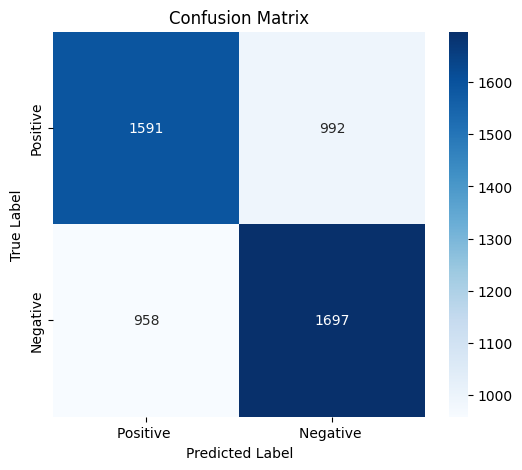

In [40]:
y_pred = log_reg.predict(atributes_test)

# Compute confusion matrix
cm = confusion_matrix(target_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Positive ", "Negative "], yticklabels=["Positive", "Negative"])
plt.title("Confusion Matrix")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

we can see the cofs of the model and try to remove noise(if the model has one)
after trying to clean some features we dont get an improvement

In [41]:
coef_with_names = list(zip(atributes.columns, cofs))

# Sort coefficients by absolute value to find the strongest ones
sorted_coef = sorted(coef_with_names, key=lambda x: abs(x[1]), reverse=True)

# Display the coefficients with corresponding feature names
print("Coefficients with feature names:")
for feature, coef in sorted_coef:
    print(f"{feature}: {coef}")

Coefficients with feature names:
3pa_opp_10: -29.869472016547352
3p_opp_10: 18.37666648246171
mp_10: -9.11695173842433
mp_opp_10: 4.9399311206082395
orb_opp_10: 4.939931120608227
season: 4.902625920606702
total_10: -4.525308945880671
orb_10: 3.0483466336491163
fga_10: -2.7095833454389817
fg_10: 2.5229711733197444
won_10: -2.154598962462325
tov_10: 2.0590750135272247
3pa_10: -1.8383945093722844
3p_10: 1.3720861071161132
ortg_10: 1.1653563092527988
fg_opp_10: 1.1342803961110137
home: -0.9503505103598007
fga_opp_10: 0.9066876120910624
pts_10: 0.7094705081666521
trb_10: 0.6875889146308674
drtg_10: 0.48773254604425786
tov_opp_10: -0.1415648792064992
trb_opp_10: 0.13393847667663805


## Conclusion

The model is not overfitting or underfitting, because the accuracy on the test data and the train data is the same.
The dataframe is balanced. Getting the avrage result from more than 10 games might improve the result(it may give more consistent team statistics).
But the data itself might be the biggest problem. If the model has more information like: which players are playing, the individual stats of the 
players, information about teams practise games, coaches and etc. Overall the model did pretty good with the data it had avaliable.